In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from collections import Counter
from scipy.stats import randint as sp_randint
import math

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings('ignore')

In [182]:
df = pd.read_csv('transport_data/transport_data.csv')
df['log']=df['log']
df['lat']=df['lat']
df.head()

log        lat  request_ts    trans_ts label
0  30.295780  59.932167  1511956827  1511956594     0
1  30.219528  59.954617  1511956827  1511956746     -
2  30.409101  59.931679  1511956827  1511956747     -
3  30.293602  59.938892  1511956827  1511956759     -
4  30.360102  59.931103  1511956827  1511956767     -

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58665 entries, 0 to 58664
Data columns (total 5 columns):
log           58665 non-null float64
lat           58665 non-null float64
request_ts    58665 non-null int64
trans_ts      58665 non-null int64
label         58665 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 2.2+ MB


In [184]:
df.head()

log        lat  request_ts    trans_ts label
0  30.295780  59.932167  1511956827  1511956594     0
1  30.219528  59.954617  1511956827  1511956746     -
2  30.409101  59.931679  1511956827  1511956747     -
3  30.293602  59.938892  1511956827  1511956759     -
4  30.360102  59.931103  1511956827  1511956767     -

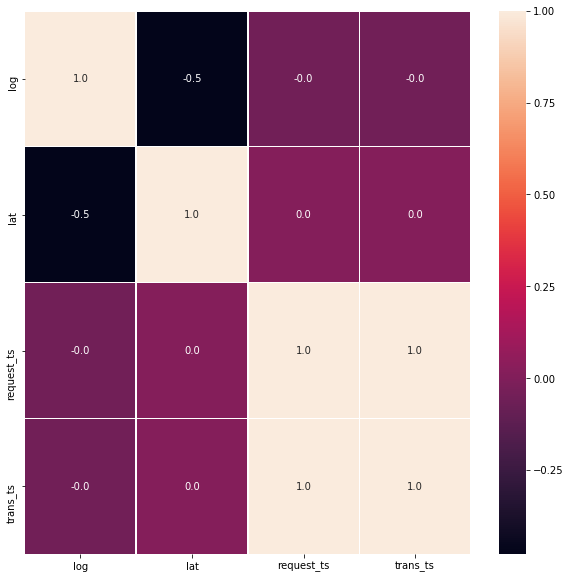

In [185]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Data size = (10000, 5)
Label 0: 4423
Label 1: 3372
Label 2: 2205


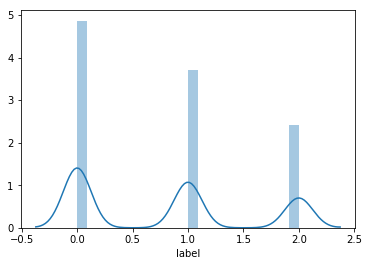

In [186]:
data = df[(df.label!='?') & (df.label!='-')]

print('Data size =', data.shape)
print('Label 0:',len(data[data.label=='0']))
print('Label 1:',len(data[data.label=='1']))
print('Label 2:',len(data[data.label=='2']))

sns.distplot(data['label'].astype('int'))

In [187]:
# #ДЛЯ ТЕСТОВ
# split = 9000
# test = data[split:]
# data = data[:split]

# print('Data size =', data.shape)
# print('Label 0:',len(data[data.label=='0']))
# print('Label 1:',len(data[data.label=='1']))
# print('Label 2:',len(data[data.label=='2']))

# print('Data size =', test.shape)
# print('Label 0:',len(test[test.label=='0']))
# print('Label 1:',len(test[test.label=='1']))
# print('Label 2:',len(test[test.label=='2']))

# data.head()

(10000, 1)
Разница меток времени больше  500 y 154


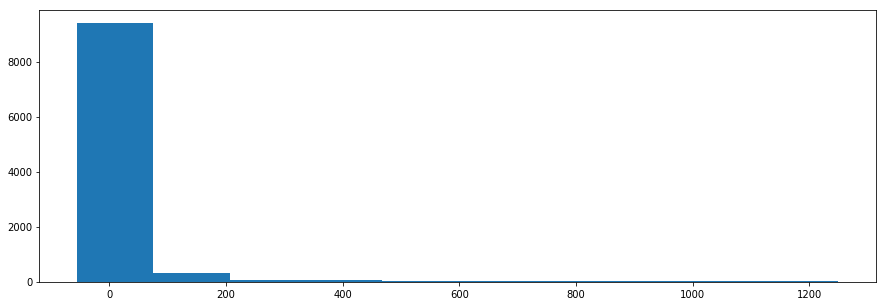

In [188]:
plotdata = pd.DataFrame(data=(data['request_ts']-data['trans_ts']),columns=['dif'])
print(plotdata.shape)
l = 500
print('Разница меток времени больше ', l, 'y', sum(plotdata['dif'] > 500))
fig, axs = plt.subplots(figsize=(15, 5))
a = axs.hist(plotdata['dif'])


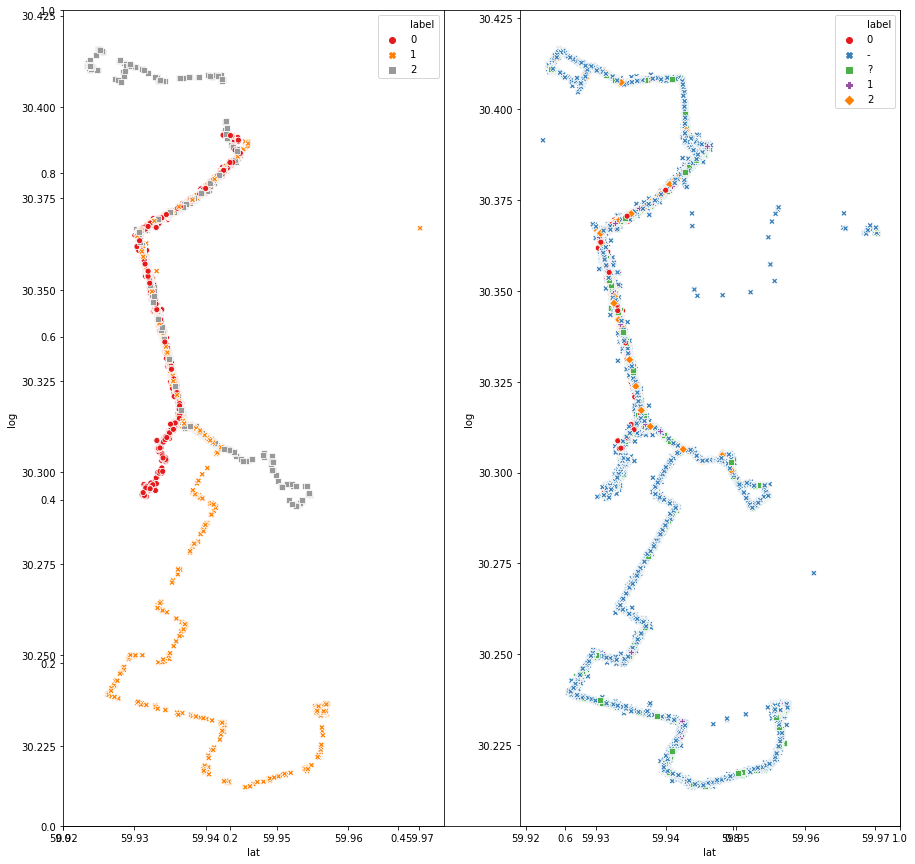

In [189]:
fig, ax = plt.subplots(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
temp = data
temp['label'] = temp['label'].astype('int8')
a = sns.scatterplot(x='lat', y='log', data=temp, hue="label", style="label", palette="Set1")
fig.add_subplot(1, 2, 2)
a = sns.scatterplot(x='lat', y='log', data=df, hue="label", style="label", palette="Set1")
fig = a.get_figure()
fig.savefig('out.png')
del temp

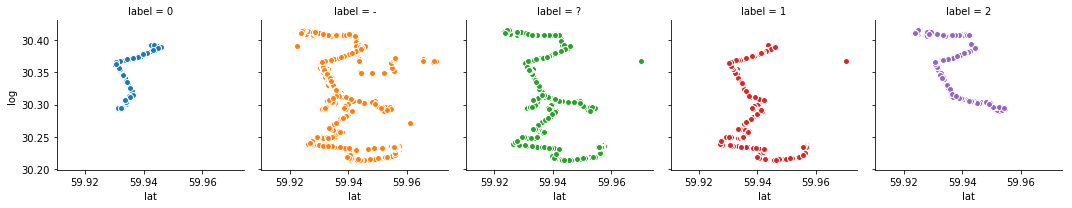

In [190]:
g = sns.FacetGrid(df, col="label", hue="label",)
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

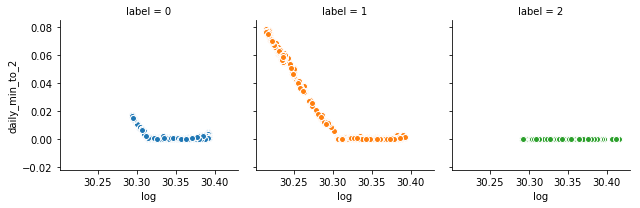

In [294]:
g = sns.FacetGrid(data, col="label", hue="label",)
g = (g.map(plt.scatter, "log", "daily_min_to_2", edgecolor="w"))

In [191]:
questions = df[df['label'] == '?']
questions=questions.drop(['label'],axis=1)
print('Надо предсказать:', len(questions))
print('Есть данные:     ', len(data))
questions.head()

Надо предсказать: 5000
Есть данные:      10000


log        lat  request_ts    trans_ts
11  30.359190  59.931217  1511956827  1511956787
18  30.355488  59.931679  1511956827  1511956811
41  30.312258  59.937222  1511956918  1511956905
42  30.367332  59.931988  1511956918  1511956907
56  30.329239  59.934929  1511956978  1511956967

In [192]:
unlable_data=df[df.label=='-']
print('Нету данных о мартшруте у ', len(unlable_data))
unlable_data.head()

Нету данных о мартшруте у  43665


log        lat  request_ts    trans_ts label
1  30.219528  59.954617  1511956827  1511956746     -
2  30.409101  59.931679  1511956827  1511956747     -
3  30.293602  59.938892  1511956827  1511956759     -
4  30.360102  59.931103  1511956827  1511956767     -
5  30.309683  59.940006  1511956827  1511956769     -

In [193]:
# сделать что-то с "-" маршрутами
unlable_mb = pd.merge(data, unlable_data, on=['log', 'lat'], how='inner')

print('Можно добавить данные размером', len(unlable_mb))

more_data=unlable_mb[['log','lat','request_ts_y','trans_ts_y','label_x']]
more_data=more_data.rename(index=str, columns={'request_ts_y': 'request_ts', 'trans_ts_y': 'trans_ts','label_x': 'label'})

Можно добавить данные размером 58459


In [194]:
# Запускать если хочешь добавить неизвестные маршруты к данным
# маршруты присвоились при совпадении координат с известными
#data = pd.concat([more_data, data])
print('Размер данных теперь =', len(data))

Размер данных теперь = 10000


In [195]:
def add_time(dataframe):
    time1=pd.DataFrame(index=dataframe.index.copy(),columns=['day'])
    time2=pd.DataFrame(index=dataframe.index.copy(),columns=['hour'])
    time3=pd.DataFrame(index=dataframe.index.copy(),columns=['day_sec'])
    time4=pd.DataFrame(index=dataframe.index.copy(),columns=['day_minutes'])

    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['trans_ts'])
        if y.hour == 0:
            hour = 24
            day = y.day - 1
            if day == 0: day =30
        else:
            hour = y.hour
            day = y.day
        time1.at[index,'day']= day
        time2.at[index,'hour']= hour
        time3.at[index,'day_sec']= hour * 3600 + y.minute * 60 + y.second
        time4.at[index,'day_minutes']= hour * 60 + y.minute 
        
    dataframe['day']=time1.astype('int')
    dataframe['hour']=time2.astype('int')
    dataframe['day_sec']=time3.astype('int')
    dataframe['day_minutes']=time4.astype('int')
    
    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['request_ts'])
        if y.hour == 0:
            hour = 24
            day = y.day - 1
            if day == 0: day =30
        else:
            hour = y.hour
            day = y.day
            
        time1.at[index,'day']= day
        time2.at[index,'hour']= hour
        time3.at[index,'day_sec']= hour * 3600 + y.minute * 60 + y.second 
        time4.at[index,'day_minutes']= hour * 60 + y.minute 
        
    dataframe['day_req']=time1.astype('int')
    dataframe['hour_req']=time2.astype('int')
    dataframe['day_sec_req']=time3.astype('int')
    dataframe['day_minutes_req']=time4.astype('int')
    return dataframe

def add_simple_time(dataframe):
    time1=pd.DataFrame(index=dataframe.index.copy(),columns=['day'])
    time2=pd.DataFrame(index=dataframe.index.copy(),columns=['hour'])
    time3=pd.DataFrame(index=dataframe.index.copy(),columns=['minute'])
    time4=pd.DataFrame(index=dataframe.index.copy(),columns=['sec'])
    time5=pd.DataFrame(index=dataframe.index.copy(),columns=['request_ts'])

    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['trans_ts'])
        time1.at[index,'day']=y.day
        time2.at[index,'hour']=y.hour
        time3.at[index,'minute']=y.minute   
        time4.at[index,'sec']=y.second
    dataframe['day']=time1
    dataframe['hour']=time2
    dataframe['minute']=time3
    dataframe['sec']=time4
    
    for index, row in dataframe.iterrows():
        y=datetime.fromtimestamp(row['request_ts'])
        time1.at[index,'day']=y.day
        time2.at[index,'hour']=y.hour
        time3.at[index,'minute']=y.minute   
        time4.at[index,'sec']=y.second
    dataframe['day__req']=time1
    dataframe['hour__req']=time2
    dataframe['minute_req']=time3
    dataframe['sec_req']=time4

    return dataframe

In [196]:
%%time
data = add_simple_time(data)
data = add_time(data)
print('Размер данных =', data.shape)

questions = add_simple_time(questions)
questions = add_time(questions)
print('Размер данных с неисвестными маршрутами =', questions.shape)
data.head()

Размер данных = (10000, 19)
Размер данных с неисвестными маршрутами = (5000, 18)
Wall time: 7.92 s


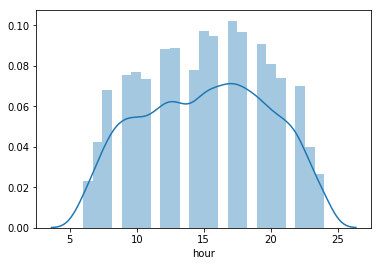

In [197]:
sns.distplot(data['hour'].astype('int'))

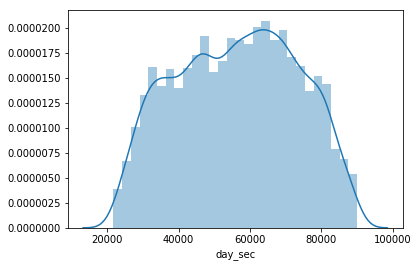

In [198]:
sns.distplot(data['day_sec'].astype('int'))

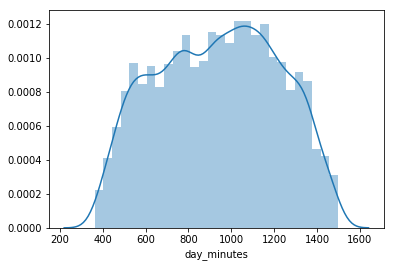

In [199]:
sns.distplot(data['day_minutes'].astype('int'))

In [200]:
# точный ооочень долгий способ
def geodesic(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km
    
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [201]:
# не такой долгий способ
def geodesic(one,two):
    return math.sqrt((one[0]-two[0])** 2+(one[1]-two[1])** 2)

In [202]:
def add_simple_distance(dataframe, data):
    # dataframe - куда добавляем
    # data - откуда берем ближайшие точки
    way_0 = data[data['label'] == 0]
    way_1 = data[data['label'] == 1]
    way_2 = data[data['label'] == 2]

    dist_0 = []
    dist_1 = []
    dist_2 = []
    
    avg_dist_0 = []
    avg_dist_1 = []
    avg_dist_2 = []
    print('Надо обработать:', len(dataframe))

    for index, row in dataframe.iterrows():
        
        # 0 маршрут
        dist = 1000000
        avg_d = 0
        for i, r in way_0.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_0.append(dist)
        avg_dist_0.append(avg_d/len(way_0))
        
        # 1 маршрут
        dist = 1000000
        avg_d = 0
        for i, r in way_1.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_1.append(dist)
        avg_dist_1.append(avg_d/len(way_1))

        # 2 маршрут
        dist = 1000000
        avg_d = 0
        for i, r in way_2.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_2.append(dist)
        avg_dist_2.append(avg_d/len(way_2))
        
        if len(dist_2) % 1000 == 0:
            print('Обработано:', len(dist_2))
   
    dataframe['min_to_0'] = dist_0
    dataframe['min_to_1'] = dist_1
    dataframe['min_to_2'] = dist_2
    
    dataframe['avg_to_0'] = avg_dist_0
    dataframe['avg_to_1'] = avg_dist_1
    dataframe['avg_to_2'] = avg_dist_2
    
    return dataframe

In [220]:
def add_dayly_distance(dataframe, data):
    # dataframe - куда добавляем
    # data - откуда берем ближайшие точки
    way_0 = data[data['label'] == 0]
    way_1 = data[data['label'] == 1]
    way_2 = data[data['label'] == 2]

    dist_0 = []
    dist_1 = []
    dist_2 = []
    
    avg_dist_0 = []
    avg_dist_1 = []
    avg_dist_2 = []
    print('Надо обработать:', len(dataframe))

    for index, row in dataframe.iterrows():
        cur_day = row['day']

        # 0 маршрут
        way_0_cur_day = way_0[way_0['day'] == cur_day]
        dist = 1000000
        avg_d = 0
        for i, r in way_0_cur_day.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_0.append(dist)
        avg_dist_0.append(avg_d/len(way_0_cur_day))
        
        # 1 маршрут
        way_1_cur_day = way_1[way_1['day'] == cur_day]
        dist = 1000000
        avg_d = 0
        for i, r in way_1_cur_day.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_1.append(dist)
        avg_dist_1.append(avg_d/len(way_1_cur_day))

        # 2 маршрут
        way_2_cur_day = way_2[way_2['day'] == cur_day]
        dist = 1000000
        avg_d = 0
        for i, r in way_2_cur_day.iterrows():
            new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
            avg_d += new_dist
            if new_dist < dist:
                dist = new_dist
            if new_dist == 0:
                break
        dist_2.append(dist)
        avg_dist_2.append(avg_d/len(way_2_cur_day))
        
        if len(dist_2) % 1000 == 0:
            print('Обработано:', len(dist_2))
   
    dataframe['daily_min_to_0'] = dist_0
    dataframe['daily_min_to_1'] = dist_1
    dataframe['daily_min_to_2'] = dist_2
    
    dataframe['daily_avg_to_0'] = avg_dist_0
    dataframe['daily_avg_to_1'] = avg_dist_1
    dataframe['daily_avg_to_2'] = avg_dist_2
    
    return dataframe

In [204]:
def add_nearest_distance_intime(dataframe, data, what_time= 'day_sec', time_radius= 10, near_time= 30, min_dist=0.01 ,max_dist=1.):
    # dataframe - куда добавляем
    # data - откуда берем ближайшие точки
    # время каждого дня измеряем в what_time
    print('Надо обработать:', len(dataframe))
    
    way_0 = data[data['label'] == 0]
    way_1 = data[data['label'] == 1]
    way_2 = data[data['label'] == 2]

    time_0_l = []
    time_0_h = []
    time_1_l = []
    time_1_h = []
    time_2_l = []
    time_2_h = []

    dist_0_l = []
    dist_0_h = []
    dist_1_l = []
    dist_1_h = []
    dist_2_l = []
    dist_2_h = []
    

    for index, row in dataframe.iterrows():
        cur_day = row['day']
        cur_time = row[what_time]

        # 0 маршрут
        way0_cur_day = way_0[way_0['day'] == cur_day]
        nearest_time_l = (way0_cur_day[way0_cur_day[what_time]  < cur_time - near_time])[what_time].max()
        nearest_time_h = (way0_cur_day[way0_cur_day[what_time]  > cur_time + near_time])[what_time].min()
        
        if math.isnan(nearest_time_l):
            nearest_time_l = cur_time + 1
            dist_0_l.append(-2)
        else:
            pretend = way0_cur_day[(way0_cur_day[what_time] > nearest_time_l - time_radius) & (way0_cur_day[what_time] < nearest_time_l + time_radius)]
            dist = time_radius0
            new_nearest_time_l = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_l = r[what_time]
                    
            if dist != time_radius0:
                dist_0_l.append(dist)
                nearest_time_l = new_nearest_time_l
            else:
                dist_0_l.append(-1)
                nearest_time_l = cur_time + 1
                
           
        if math.isnan(nearest_time_h):
            nearest_time_h = cur_time - 1
            dist_0_h.append(-2)
        else:
            pretend = way0_cur_day[(way0_cur_day[what_time] > nearest_time_h - time_radius) & (way0_cur_day[what_time] < nearest_time_h + time_radius)]
            dist = time_radius0
            new_nearest_time_h = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_h = r[what_time]

            if dist != time_radius0:
                dist_0_h.append(dist)
                nearest_time_h = new_nearest_time_h
            else:
                dist_0_h.append(-1)
                nearest_time_h = cur_time + 1

        time_0_l.append(int(cur_time - nearest_time_l))
        time_0_h.append(int(nearest_time_h - cur_time))

        # 1 маршрут
        way1_cur_day = way_1[way_1['day'] == cur_day]
        nearest_time_l = (way1_cur_day[way1_cur_day[what_time]  < cur_time - near_time])[what_time].max()
        nearest_time_h = (way1_cur_day[way1_cur_day[what_time]  > cur_time + near_time])[what_time].min()
        
        if math.isnan(nearest_time_l):
            nearest_time_l = cur_time + 1
            dist_1_l.append(-2)
        else:
            pretend = way1_cur_day[(way1_cur_day[what_time] > nearest_time_l - time_radius) & (way1_cur_day[what_time] < nearest_time_l + time_radius)]
            dist = time_radius0
            new_nearest_time_l = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_l = r[what_time]
                    
            if dist != time_radius0:
                dist_1_l.append(dist)
                nearest_time_l = new_nearest_time_l
            else:
                dist_1_l.append(-1)
                nearest_time_l = cur_time + 1
                
           
        if math.isnan(nearest_time_h):
            nearest_time_h = cur_time - 1
            dist_1_h.append(-2)
        else:
            pretend = way1_cur_day[(way1_cur_day[what_time] > nearest_time_h - time_radius) & (way1_cur_day[what_time] < nearest_time_h + time_radius)]
            dist = time_radius0
            new_nearest_time_h = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_h = r[what_time]

            if dist != time_radius0:
                dist_1_h.append(dist)
                nearest_time_h = new_nearest_time_h
            else:
                dist_1_h.append(-1)
                nearest_time_h = cur_time + 1

        time_1_l.append(int(cur_time - nearest_time_l))
        time_1_h.append(int(nearest_time_h - cur_time))

        # 2 маршрут
        way2_cur_day = way_2[way_2['day'] == cur_day]
        nearest_time_l = (way2_cur_day[way2_cur_day[what_time]  < cur_time - near_time])[what_time].max()
        nearest_time_h = (way2_cur_day[way2_cur_day[what_time]  > cur_time + near_time])[what_time].min()
        
        if math.isnan(nearest_time_l):
            nearest_time_l = cur_time + 1
            dist_2_l.append(-2)
        else:
            pretend = way2_cur_day[(way2_cur_day[what_time] > nearest_time_l - time_radius) & (way2_cur_day[what_time] < nearest_time_l + time_radius)]
            dist = time_radius0
            new_nearest_time_l = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_l = r[what_time]
                    
            if dist != time_radius0:
                dist_2_l.append(dist)
                nearest_time_l = new_nearest_time_l
            else:
                dist_2_l.append(-1)
                nearest_time_l = cur_time + 1
                
           
        if math.isnan(nearest_time_h):
            nearest_time_h = cur_time - 1
            dist_2_h.append(-2)
        else:
            pretend = way2_cur_day[(way2_cur_day[what_time] > nearest_time_h - time_radius) & (way2_cur_day[what_time] < nearest_time_h + time_radius)]
            dist = time_radius0
            new_nearest_time_h = -1
            for i, r in pretend.iterrows():
                new_dist = geodesic((row['lat'], row['log']), (r['lat'], r['log']))
                if new_dist > min_dist and new_dist < max_dist and new_dist < dist:
                    dist = new_dist
                    new_nearest_time_h = r[what_time]

            if dist != time_radius0:
                dist_2_h.append(dist)
                nearest_time_h = new_nearest_time_h
            else:
                dist_2_h.append(-1)
                nearest_time_h = cur_time + 1

        time_2_l.append(int(cur_time - nearest_time_l))
        time_2_h.append(int(nearest_time_h - cur_time))

        if len(time_2_l) % 1000 == 0:
            print('Обработано:', len(time_2_l))
            
            
    dataframe['time_low_0'] = time_0_l
    dataframe['time_high_0'] = time_0_h
    dataframe['dist_low_0'] = dist_0_l
    dataframe['dist_high_0'] = dist_0_h

    dataframe['time_low_1'] = time_1_l
    dataframe['time_high_1'] = time_1_h
    dataframe['dist_low_1'] = dist_1_l
    dataframe['dist_high_1'] = dist_1_h

    dataframe['time_low_2'] = time_2_l
    dataframe['time_high_2'] = time_2_h
    dataframe['dist_low_2'] = dist_2_l
    dataframe['dist_high_2'] = dist_2_h
    
    return dataframe

In [219]:
%%time
#a = add_nearest_sm(questions, data, 'day_sec')
#a = add_nearest_sm(data, data, 'day_sec')
a = add_dayly_distance(data, data)
a = add_dayly_distance(questions, data)
data.head()

Надо обработать: 9999
Обработано: 0
Обработано: 1000
Обработано: 10000
Обработано: 12000
Обработано: 18000
Обработано: 23000
Обработано: 30000
Обработано: 31000
Обработано: 36000
Обработано: 39000
Обработано: 45000
Обработано: 46000
Обработано: 55000
Надо обработать: 5000
Обработано: 6000
Обработано: 24000
Обработано: 38000
Обработано: 56000
Wall time: 1h 23min 59s


In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 0 to 58662
Data columns (total 31 columns):
log                9999 non-null float64
lat                9999 non-null float64
request_ts         9999 non-null int64
trans_ts           9999 non-null int64
label              9999 non-null int8
day                9999 non-null int32
hour               9999 non-null int32
minute             9999 non-null object
sec                9999 non-null object
day__req           9999 non-null object
hour__req          9999 non-null object
minute_req         9999 non-null object
sec_req            9999 non-null object
day_sec            9999 non-null int32
day_minutes        9999 non-null int32
day_req            9999 non-null int32
hour_req           9999 non-null int32
day_sec_req        9999 non-null int32
day_minutes_req    9999 non-null int32
min_to_0           9999 non-null float64
min_to_1           9999 non-null float64
min_to_2           9999 non-null float64
avg_to_0           

In [226]:
data.head

array([0.00000000e+00, 0.00000000e+00, 2.59427462e-05, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [206]:
data['min_to_0'] = np.loadtxt("data_min_to_0.txt", delimiter=',', dtype=np.float)
data['min_to_1'] = np.loadtxt("data_min_to_1.txt", delimiter=',', dtype=np.float)
data['min_to_2'] = np.loadtxt("data_min_to_2.txt", delimiter=',', dtype=np.float)

data['avg_to_0'] = np.loadtxt("data_avg_to_0.txt", delimiter=',', dtype=np.float)
data['avg_to_1'] = np.loadtxt("data_avg_to_1.txt", delimiter=',', dtype=np.float)
data['avg_to_2'] = np.loadtxt("data_avg_to_2.txt", delimiter=',', dtype=np.float)
data.head()

log        lat  request_ts    trans_ts  label  day  hour minute sec  \
0   30.295780  59.932167  1511956827  1511956594      0   29    14     56  34   
8   30.385973  59.944260  1511956827  1511956782      0   29    14     59  42   
13  30.374880  59.938213  1511956827  1511956802      1   29    15      0   2   
17  30.347544  59.932667  1511956827  1511956811      0   29    15      0  11   
23  30.312321  59.937405  1511956827  1511956820      2   29    15      0  20   

   day__req    ...    day_req hour_req day_sec_req  day_minutes_req  min_to_0  \
0        29    ...         29       15       54027              900  0.000000   
8        29    ...         29       15       54027              900  0.000061   
13       29    ...         29       15       54027              900  0.000026   
17       29    ...         29       15       54027              900  0.000000   
23       29    ...         29       15       54027              900  0.001549   

    min_to_1  min_to_2  avg_to_0  avg_to_1  avg_to_2  
0   0.006068  0.014694  0.051811  0.050136  0.055522  
8   0.000198  0.000061  0.040435  0.057019  0.041319  
13  0.000017  0.000044  0.029532  0.045948  0.031866  
17  0.000000  0.000000  0.020518  0.032605  0.024715  
23  0.000034  0.000004  0.036717  0.038642  0.039929  

[5 rows x 25 columns]

In [207]:
questions['min_to_0'] = np.loadtxt("questions_min_to_0.txt", delimiter=',', dtype=np.float)
questions['min_to_1'] = np.loadtxt("questions_min_to_1.txt", delimiter=',', dtype=np.float)
questions['min_to_2'] = np.loadtxt("questions_min_to_2.txt", delimiter=',', dtype=np.float)

questions['avg_to_0'] = np.loadtxt("questions_avg_to_0.txt", delimiter=',', dtype=np.float)
questions['avg_to_1'] = np.loadtxt("questions_avg_to_1.txt", delimiter=',', dtype=np.float)
questions['avg_to_2'] = np.loadtxt("questions_avg_to_2.txt", delimiter=',', dtype=np.float)
questions.head()

log        lat  request_ts    trans_ts  day  hour minute sec  \
11  30.359190  59.931217  1511956827  1511956787   29    14     59  47   
18  30.355488  59.931679  1511956827  1511956811   29    15      0  11   
41  30.312258  59.937222  1511956918  1511956905   29    15      1  45   
42  30.367332  59.931988  1511956918  1511956907   29    15      1  47   
56  30.329239  59.934929  1511956978  1511956967   29    15      2  47   

   day__req hour__req    ...    day_req hour_req  day_sec_req  \
11       29        15    ...         29       15        54027   
18       29        15    ...         29       15        54027   
41       29        15    ...         29       15        54118   
42       29        15    ...         29       15        54118   
56       29        15    ...         29       15        54178   

    day_minutes_req  min_to_0  min_to_1  min_to_2  avg_to_0  avg_to_1  \
11              900  0.000006  0.000011  0.000013  0.020811  0.035496   
18              900  0.000036  0.000038  0.000000  0.020295  0.034208   
41              901  0.001412  0.000000  0.000000  0.036742  0.038676   
42              901  0.000042  0.000077  0.000058  0.023939  0.039839   
56              902  0.000018  0.000087  0.000441  0.026016  0.033402   

    avg_to_2  
11  0.024680  
18  0.024270  
41  0.039978  
42  0.027202  
56  0.030357  

[5 rows x 24 columns]

In [278]:
# балансировка элементов каждого маршрута
def data_balancing(dataframe):
    label_0 = dataframe[dataframe['label'] == 0]
    label_1 = dataframe[dataframe['label'] == 1]
    label_2 = dataframe[dataframe['label'] == 2]
    
    f = len(label_0) / len(label_1) - 1
    if f > 1: f = 1
    add_1 = label_1.sample(frac=f)
    
    f = len(label_0) / len(label_2) - 1
    if f > 1: f = 1
    add_2 = label_2.sample(frac=f)
    
    dataframe_balance = pd.concat([dataframe,add_1,add_2])
    return dataframe_balance

Counter({0: 4423, 1: 3371, 2: 2205})


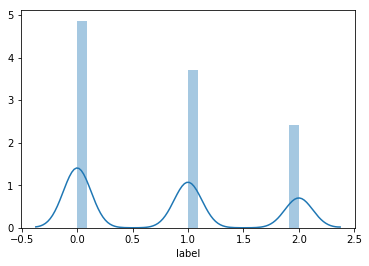

In [279]:
sns.distplot(data['label'].astype('int'))
print(Counter(data['label'].astype('int')))

Counter({0: 4423, 1: 4423, 2: 4410})
(13256, 31)


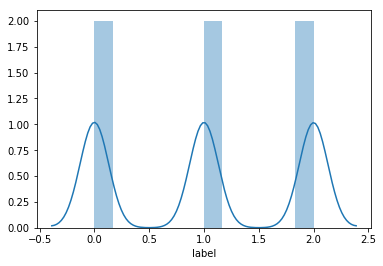

In [280]:
data = data_balancing(data)
sns.distplot(data['label'].astype('int'))
print(Counter(data['label'].astype('int')))
print(data.shape)

In [31]:
def del_features(dataframe, features):
    return dataframe.drop(features, axis=1)

59.9700813293457
59.9571762084961


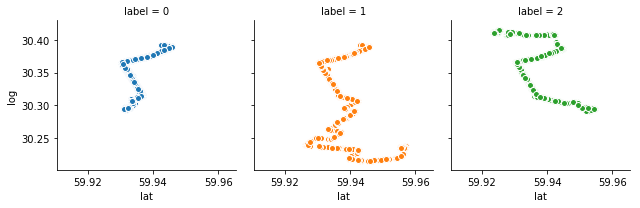

In [210]:
# выброс
max_lat=data['lat'].max()
print(max_lat)
if max_lat > 0.97:
    data.drop(data[data['lat'] == max_lat].index, inplace=True)
print(data['lat'].max())
g = sns.FacetGrid(data, col="label", hue="label",)
g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))

In [277]:
copy_data = data
print(copy_data.shape)
copy_data.columns

(9999, 31)


Index(['log', 'lat', 'request_ts', 'trans_ts', 'label', 'day', 'hour',
       'minute', 'sec', 'day__req', 'hour__req', 'minute_req', 'sec_req',
       'day_sec', 'day_minutes', 'day_req', 'hour_req', 'day_sec_req',
       'day_minutes_req', 'min_to_0', 'min_to_1', 'min_to_2', 'avg_to_0',
       'avg_to_1', 'avg_to_2', 'daily_min_to_0', 'daily_min_to_1',
       'daily_min_to_2', 'daily_avg_to_0', 'daily_avg_to_1', 'daily_avg_to_2'],
      dtype='object')

In [218]:
data = copy_data
print(data.shape)
data.columns

(9999, 25)


Index(['log', 'lat', 'request_ts', 'trans_ts', 'label', 'day', 'hour',
       'minute', 'sec', 'day__req', 'hour__req', 'minute_req', 'sec_req',
       'day_sec', 'day_minutes', 'day_req', 'hour_req', 'day_sec_req',
       'day_minutes_req', 'min_to_0', 'min_to_1', 'min_to_2', 'avg_to_0',
       'avg_to_1', 'avg_to_2'],
      dtype='object')

# Конец работы с данными

In [250]:
def plot_itenerary(pred, X):
    p = pd.DataFrame(pred, columns=['label_'])
    p = p.reindex(X.index.values)
    p['label_'] = pred
    
    print(Counter(pred))
    X = pd.concat([X, p], axis=1)
    fig, ax = plt.subplots(figsize=(15, 15))
    
    a = sns.scatterplot(x='lat', y='log', data=X, hue="label_", style="label_", palette=["blue", "yellow", "green"])
    
    #a = sns.scatterplot(x='lat', y='log', data=X, hue="label_", style="label_", palette='Set1')
    
    g = sns.FacetGrid(X, col="label_", hue="label_",)
    g = (g.map(plt.scatter, "lat", "log", edgecolor="w"))


In [ ]:
0 ['log'] < 30.290 = 433

1

2 ['log'] > 30.393 = 177

Counter({0: 4423, 1: 4423, 2: 4410})


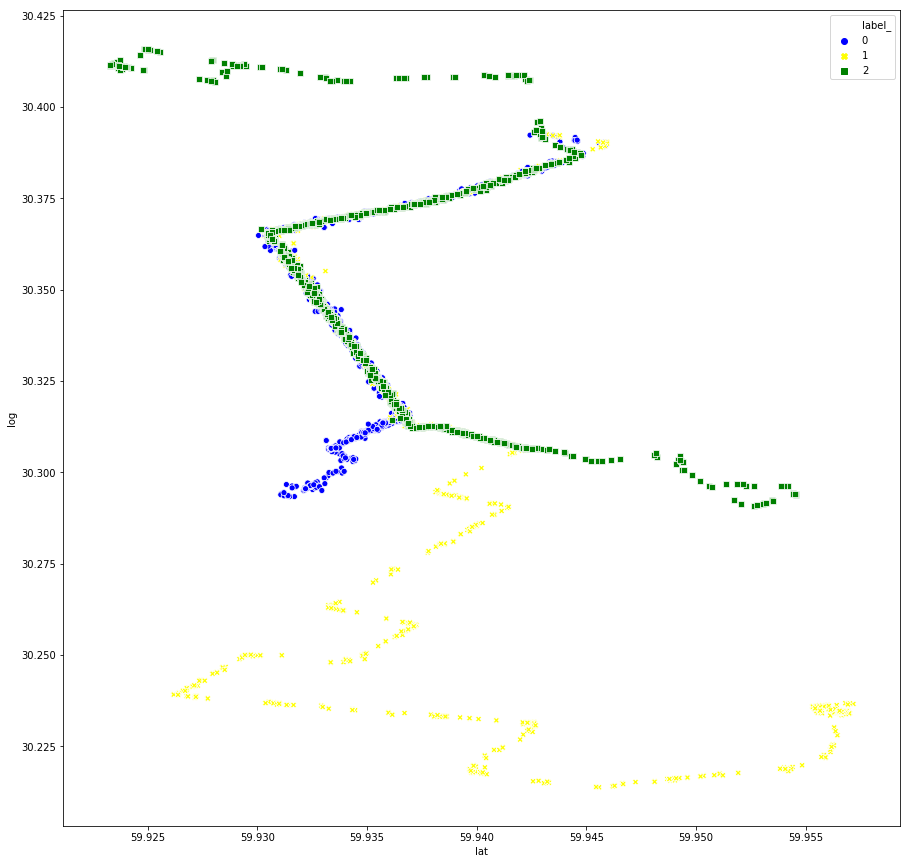

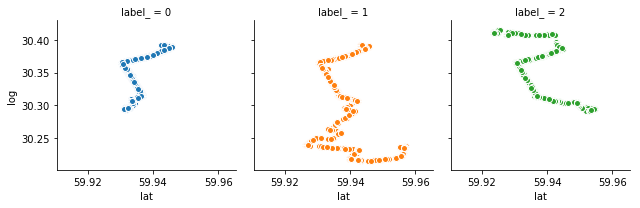

In [281]:
X_train = data.drop(['label'], axis=1)
y_train = data['label'].astype('int')
plot_itenerary(y_train, X_train)

In [286]:
# del_f = ['hour','day_req','hour_req','hour_req']
del_f = ['daily_min_to_0', 'daily_min_to_1', 'daily_min_to_2']

Counter({0: 2534, 1: 1504, 2: 962})


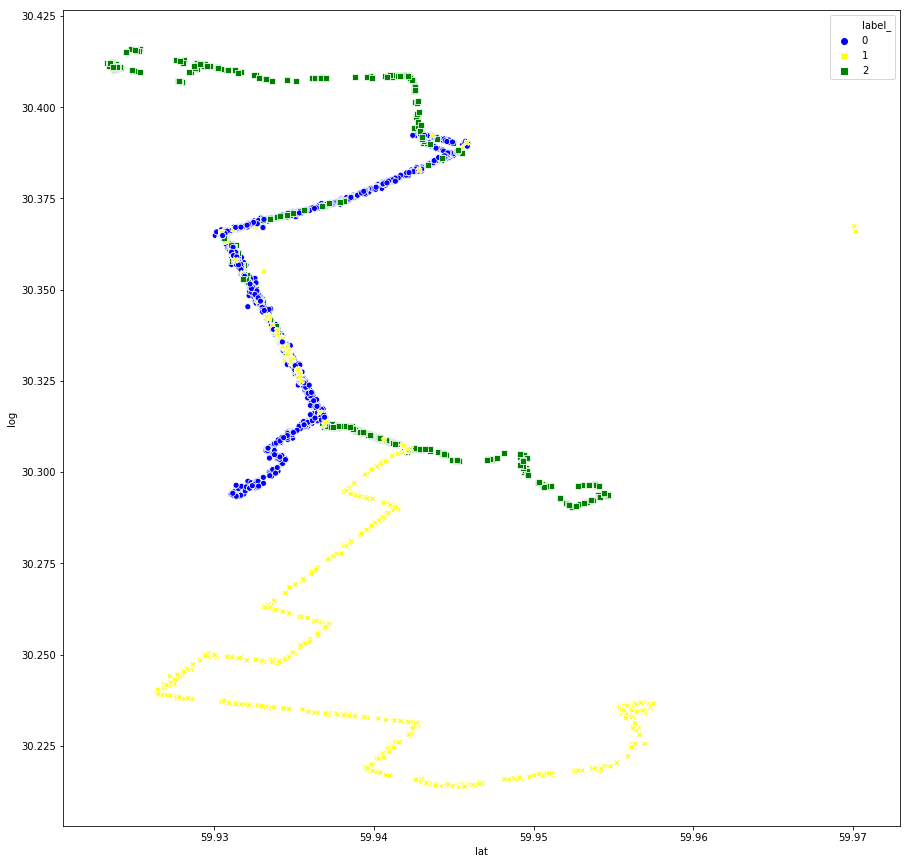

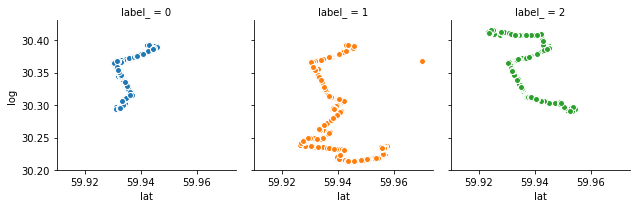

In [287]:
clf = RandomForestClassifier(max_depth= 10, bootstrap=True, n_estimators=1000, verbose=0)

clf.fit(del_features(X_train, del_f), y_train)

prediction = clf.predict(del_features(questions, del_f))

plot_itenerary(prediction, questions)

In [295]:
print (Counter(prediction))
out = open('too_bad.txt', 'w')

for i in prediction:
    out.write(str(i) + '\n') 
out.close()

Counter({0: 2534, 1: 1504, 2: 962})


In [285]:
imp = list(zip(clf.feature_importances_, X_train.columns))
imp

[(0.009039576782419352, 'log'),
 (0.004395029838532175, 'lat'),
 (0.0032604236343433323, 'request_ts'),
 (0.003414474933375159, 'trans_ts'),
 (0.0005503749571418884, 'day'),
 (0.002454444373364563, 'hour'),
 (0.0025261834355814073, 'minute'),
 (0.002173687522289288, 'sec'),
 (0.0004943538522060325, 'day__req'),
 (0.0019108584417025787, 'hour__req'),
 (0.0020904931889088032, 'minute_req'),
 (0.0024602299073797, 'sec_req'),
 (0.005484793903768093, 'day_sec'),
 (0.004872699426934034, 'day_minutes'),
 (0.0005723562271940817, 'day_req'),
 (0.0025612945733494005, 'hour_req'),
 (0.005128199020469662, 'day_sec_req'),
 (0.004828967759582868, 'day_minutes_req'),
 (0.020107096509322086, 'min_to_0'),
 (0.009661955348934968, 'min_to_1'),
 (0.01274275078058414, 'min_to_2'),
 (0.006367195963900701, 'avg_to_0'),
 (0.004288527694357356, 'avg_to_1'),
 (0.007880661783807997, 'avg_to_2'),
 (0.20025685575103913, 'daily_min_to_0'),
 (0.20971760847250473, 'daily_min_to_1'),
 (0.2242851498922006, 'daily_min_t

In [636]:
Counter({'0': 2242, '1': 1879, '2': 879})
Counter({0: 2140, 1: 1856, 2: 1004})

Counter({0: 3260, 1: 1334, 2: 406})

In [239]:
# Масштабирование
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(questions)

X_train = pd.DataFrame(X_train, columns=data.drop(['label'], axis=1).columns)
X_test = pd.DataFrame(X_test, columns=questions.columns)

In [245]:
X_train.columns

Index(['log', 'lat', 'request_ts', 'trans_ts', 'day', 'hour', 'minute', 'sec',
       'day__req', 'hour__req', 'minute_req', 'sec_req', 'day_sec',
       'day_minutes', 'day_req', 'hour_req', 'day_sec_req', 'day_minutes_req',
       'min_to_0', 'min_to_1', 'min_to_2', 'avg_to_0', 'avg_to_1', 'avg_to_2',
       'daily_min_to_0', 'daily_min_to_1', 'daily_min_to_2', 'daily_avg_to_0',
       'daily_avg_to_1', 'daily_avg_to_2'],
      dtype='object')

In [266]:
del_f = ['minute', 'sec', 'day__req', 'hour__req', 'minute_req', 'sec_req', 'min_to_0', 'min_to_1', 'min_to_2', 'avg_to_0', 'avg_to_1', 'avg_to_2',
       'daily_min_to_0', 'daily_min_to_1', 'daily_min_to_2', 'daily_avg_to_0',
       'daily_avg_to_1', 'daily_avg_to_2']

Counter({0: 2202, 1: 1911, 2: 887})


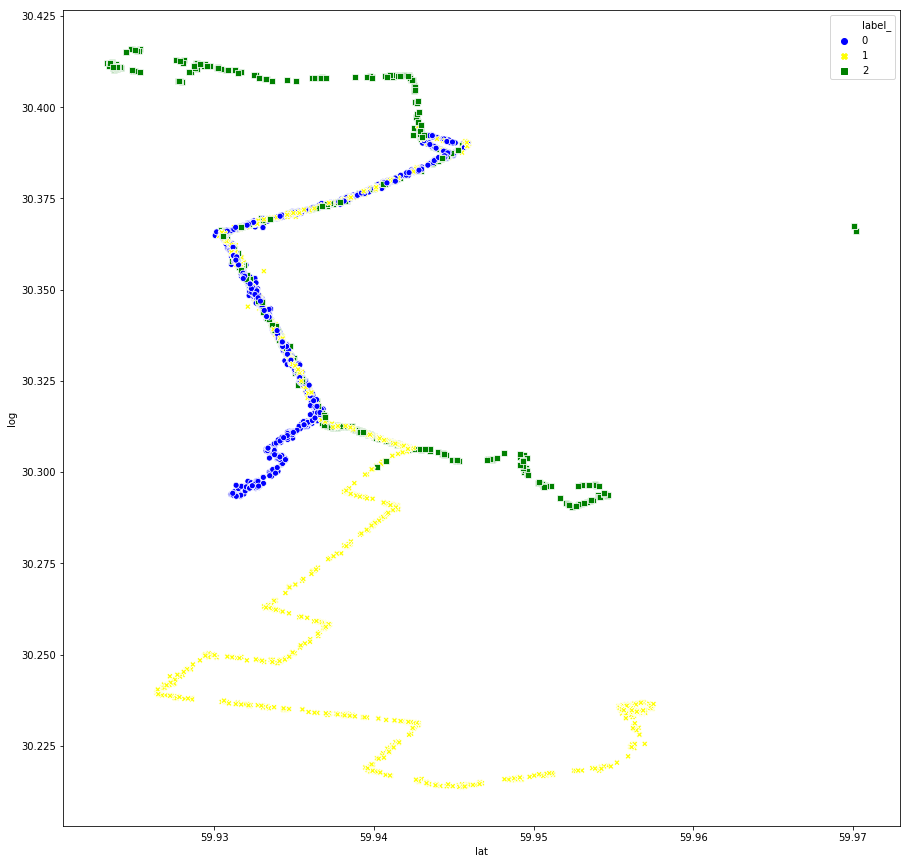

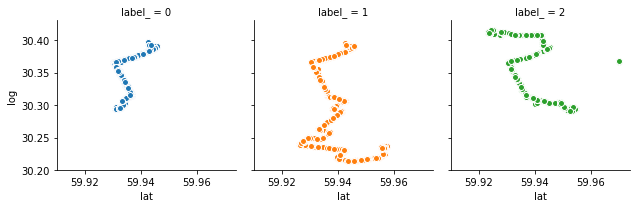

In [267]:
clf = MLPClassifier(hidden_layer_sizes=(200, 100, 50, 100,), activation='relu', learning_rate= 'invscaling', max_iter= 1000)
# del_f = []
clf.fit(del_features(X_train, del_f), y_train)

prediction = clf.predict(del_features(X_test, del_f))

plot_itenerary(prediction, questions)

In [268]:
print (Counter(prediction))
out = open('mlp_test.txt', 'w')

for i in prediction:
    out.write(str(i) + '\n') 
out.close()

Counter({0: 2202, 1: 1911, 2: 887})


In [628]:
rf=RandomForestClassifier(n_estimators = 1000, criterion = 'gini', oob_score = True,  n_jobs = -1, random_state = 42)
ab=AdaBoostClassifier(n_estimators = 10 ,random_state = 42)
dt=DecisionTreeClassifier(max_features=12, random_state=42, max_leaf_nodes=10)

xgbcl = XGBClassifier(booster='gbtree', colsample_bytree=1.0, gamma=3, learning_rate=0.001,
       max_depth=3, min_child_weight=2,
       n_estimators=1000, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0,
       seed=42, silent=True, subsample=0.8)


clf = rf

Counter({0: 2895, 1: 1632, 2: 473})


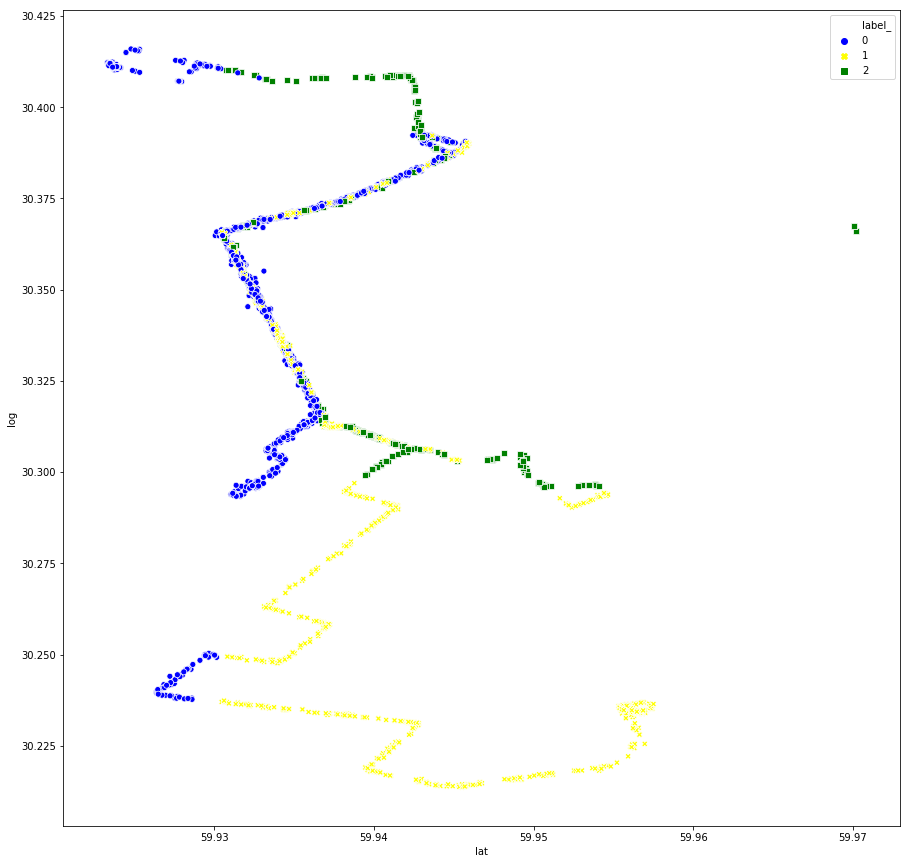

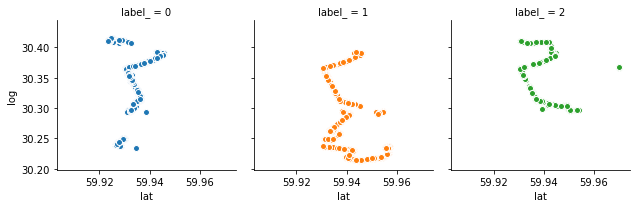

In [261]:
clf = AdaBoostClassifier(n_estimators = 3000,random_state = 42)

clf.fit(del_features(X_train, del_f), y_train)

prediction = clf.predict(del_features(X_test, del_f))

plot_itenerary(prediction, questions)

Counter({0: 3230, 1: 1360, 2: 410})


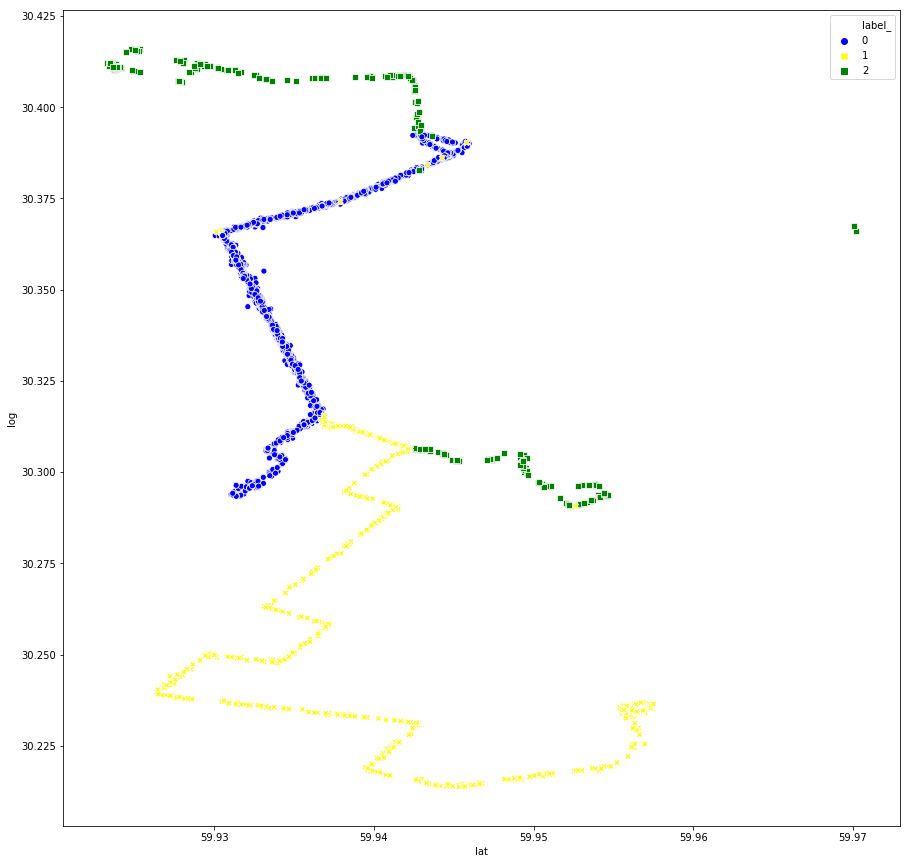

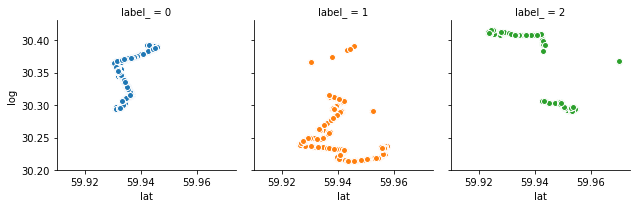

In [260]:
clf = XGBClassifier(booster='gbtree', colsample_bytree=1.0, gamma=3, learning_rate=0.001,
       max_depth=5, min_child_weight=3,
       n_estimators=1000, n_jobs=1, nthread=4, objective='multi:softprob',
       random_state=0,
       seed=42, silent=True, subsample=0.8)

clf.fit(del_features(X_train, del_f), y_train)

prediction = clf.predict(del_features(X_test, del_f))

plot_itenerary(prediction, questions)